<center><img src="http://agilesoda.ai/resources/ecoletree/img/en/home/imgCi01.png"></center>
<h1 align=center><font size = 6> Lecture 6: Value-based Algorithm</font></h1>

# 0. Outlines and goals

- What if we just use a critic, without an actor?
- Extracting a policy from a value function
- The Q-learning algorithm
- Goals:
    - Understand how value functions give rise to policies
    - Understand the Q-learning algorithm
    - Understand practical considerations for Q-learning

# 1. Remind: Actor-Critic

- Two networks: actor network ($\theta$) and critic network ($\phi$)
![alt](../assets/img/ac_recap.png)

# 2. Value-based algorithms
- Omit actor part
- Only use Critic part
- How can we do this?
    - Only use Q values to take decisions
![alt](../assets/img/q_value.png)

# 3. Remind: Relationship between ${\cal Q}$ and ${\cal V}$

- ${\cal Q}$ from ${\cal V}$

\begin{align}
{\cal Q} (s,a) = \sum_{s' \in S} p(s' | s, a) \bigg[ R(s,a,s') + \gamma {\cal V} (s')\bigg]
\end{align}

- ${\cal V}$ from ${\cal Q}$

\begin{align}
{\cal V} (s) = \sum_{a \in A} \pi(a|s) {\cal Q} (s,a)
\end{align}

# 3. Remind: one-steps Q value
- One-step Q value:

\begin{align}
{\cal Q} (s_t,a_t) \approx R_t + \gamma {\cal V} (s_{t+1})
\end{align}

- In Q-learning:

\begin{align}
{\cal V} (s) = \max_a {\cal Q} (s,a)
\end{align}

- How to take decision:

\begin{align}
a = arg \max_a {\cal Q} (s,a)
\end{align}

# 4. Q-Learning algorithm

\begin{align}
TD_{error} = {\cal A} (s_t,a_t) = {\cal Q} (s_t,a_t) - {\cal V} (s_t) \approx R_t + \gamma \max_a {\cal Q} (s_{t+1},a) - {\cal Q} (s_t,a_t)
\end{align}

![alt](../assets/img/q_learning.jpeg)

# 5. Q-Learning algorithm
- Clasical Q-Learning algorithm uses a table to store the Q values:
    - Number of column = number of action
    - Number of row = number of state

\begin{equation} 
a = argmax{Q(s,a)}
\end{equation}

![alt](../assets/img/q_table.png)

# 6. Curse of dimensionality
- Action: 2 actions (left or right) => the table has 2 columns
- State: color image of size 200x200 pixels => the table has $((255)^3)^{200\times200}$ rows

=> Curse of dimensionality
![alt](../assets/img/Curse_of_dimensionality.png)

# 7. Deep Q-Learning (DQN)
- Deep Q-learning uses neural network to approximate the Q value. Thus, solve the curve of dimensionality
    - Input: state (images...)
    - Output: number of actions
![alt](../assets/img/dqn.png)

# 8. DQN algorithms (Online version)
![alt](../assets/img/dqn_algorithm.png)

# 9. Correlated samples in online Q-learning
![alt](../assets/img/dqn_issue1.png)

# 10. Trick 1: replay buffers
- For each iteration:
    - 1. We collect data and store it to a replay buffer
    - 2. We randomly select a batch of transition
    - 3. Use the random batch to update the Q network.
![alt](../assets/img/dqn_trick1.png)

# 11. Target value is always changing
![alt](../assets/img/dqn_issue2.png)

# 12. Trick 2: Q-Learning with target networks
- Using a copy of Q-network (Q' network)
![alt](../assets/img/dqn_trick2.png)

# 13. Finally, DQN algorithms with replay buffers and target Q-network

![alt](../assets/img/dqn_final.png)

# 14. Practice: Implement DQN algorithm
- The agent controls a paddle that can be moved up and down and the goal is to hit the ball in a way that the opponent is not able to reach it.
- At the beginning of training, the DQN agent performs only random actions and thus gets a reward of around -21

![alt](../assets/img/pong.gif)

### Import the packages

In [1]:
import gym
from gym.wrappers import Monitor
import numpy as np
import os
import random
import sys
import tensorflow as tf
from collections import deque, namedtuple
import pickle
import matplotlib.pyplot as plt

### 14a. Preprocessing frame

- Working directly with raw images, which are 210 × 160 pixel can be computationally expensive.
- So, we need to convert the frame from RGB image (210 x 160 x 3) to gray-scale image of size (84, 84, 1)

In [2]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State

        Returns:
            A scale image [84, 84]
        """
        return sess.run(self.output, { self.input_state: state })

### 14b.  Defind the Q network
- The network follows atari deepmind paper.
    - The input layer is 4 gray-scale images (1 image is impossible to predict)
    - The first convolutional layer has 32 8x8 filters with stride 4, the second 64 4x4 filters with stride 2, and the third and final convolutional layer consists 64 3x3 filters with stride 1
    - Final hidden layer is fully-connected and consists of 512 rectifier units.
    - The output layer is a fully-connected linear layer with a single output for each valid action.
    - Use Adam (RMSProp) method to optimize a huber loss function (avoid exploding gradient problem)
    - The loss function is TD error: $R_t + \gamma \max_a {\cal Q} (s_{t+1},a) - {\cal Q} (s_t,a_t)$

In [3]:
class QNetwork():
    def __init__(self, nActions, scope="network"):
        self.scope = scope
        self.nActions = nActions
        with tf.variable_scope(scope):
            self._build_model()

    def _build_model(self):
        # Input are RGB frames of shape 84, 84 each
        self.obs_n = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="obs")
        # Scale
        inputscaled = tf.to_float(self.obs_n) / 255.0

        # Three convolutional layers
        conv1 = tf.layers.conv2d(inputscaled, 32, [8, 8], 4, "valid",
                                 kernel_initializer=tf.variance_scaling_initializer(scale=2),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name='conv1')
        conv2 = tf.layers.conv2d(conv1, 64, [4, 4], 2, "valid",
                                 kernel_initializer=tf.variance_scaling_initializer(scale=2),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name='conv2')
        conv3 = tf.layers.conv2d(conv2, 64, [3, 3], 1, "valid",
                                 kernel_initializer=tf.variance_scaling_initializer(scale=2),
                                 activation=tf.nn.relu,
                                 use_bias=False,
                                 name='conv3')

        # Fully connected layers
        flattened = tf.layers.flatten(conv3)
        fc1 = tf.layers.dense(flattened, 512,
                              kernel_initializer=tf.variance_scaling_initializer(scale=2),
                              activation=tf.nn.relu,
                              use_bias=False,
                              name='fc1')
        self.q_values = tf.layers.dense(fc1, self.nActions,
                                        kernel_initializer=tf.variance_scaling_initializer(scale=2),
                                        use_bias=False,
                                        name='q_values')

        # y = r + gamma*max Q', calculated in the main function
        self.y_n = tf.placeholder(shape=[None], dtype=tf.float32, name="target")
        # Action that was performed
        self.act_n = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")
        # Q value of the action that was performed
        action_one_hot = tf.one_hot(self.act_n, self.nActions, dtype=tf.float32)
        Q = tf.reduce_sum(self.q_values * action_one_hot, axis=1)

        # Calculate the loss
        # self.losses = tf.squared_difference(self.y_n, Q)
        self.losses = tf.losses.huber_loss(self.y_n, Q)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        # self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.00025)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.00025)
        self.train_op = self.optimizer.minimize(self.loss)

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 84, 84, 4]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated
          action values.
        """
        return sess.run(self.q_values, { self.obs_n: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 84, 84, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.obs_n: s, self.y_n: y, self.act_n: a }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

### 14c.  Build a greedy-policy using Q network
- The agent take action based on q-network and epsilon.
- The agent take action that maximizes the Q-value.
- Initially (begining of the game), the agent does not know how to play the game. So, the agent only explores (epsilon is big, epsilon = 1)
- Later, the epsilon decrease to 0.1, meaning that the agent starts exploiting more and more.

In [4]:
def greedy_policy(sess, network, obs, epsilon, nA, warmup=False):
    """
    Creates an epsilon-greedy policy based on a given Q-network and epsilon.

    Args:
        sess: tf session
        network: An network that returns q values for a given state
        nA: Number of actions in the environment.
        epsilon: t

    Returns:
        An action
    """
    if (random.random() < epsilon or warmup==True):
        action = random.randint(0, nA-1)
    else:
        q_values = network.predict(sess, np.expand_dims(obs, 0))[0]
        action = np.argmax(q_values)
    return action

### 14d.  Target network and parameter update
- We need to update the target q-network every N steps

In [5]:
class TargetNetworkUpdater:
    """Copies the parameters of the main DQN to the target DQN"""

    def __init__(self, main_dqn_vars, target_dqn_vars):
        """
        Args:
            main_dqn_vars: A list of tensorflow variables belonging to the main DQN network
            target_dqn_vars: A list of tensorflow variables belonging to the target DQN network
        """
        self.main_dqn_vars = main_dqn_vars
        self.target_dqn_vars = target_dqn_vars

    def _update_target_vars(self):
        update_ops = []
        for i, var in enumerate(self.main_dqn_vars):
            copy_op = self.target_dqn_vars[i].assign(var.value())
            update_ops.append(copy_op)
        return update_ops

    def update_networks(self, sess):
        """
        Args:
            sess: A Tensorflow session object
        Assigns the values of the parameters of the main network to the
        parameters of the target network
        """
        update_ops = self._update_target_vars()
        for copy_op in update_ops:
            sess.run(copy_op)

### 14d. The main program
- Create the environment, store video in the experiments folder

In [6]:
env = gym.envs.make("PongDeterministic-v4")
# Save path
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))

# Record videos
env = Monitor(env,
              directory=os.path.join(experiment_dir, "monitor"),
              resume=True,
              force=True)

### 14d. The main program

- Reset tensorflow network
- Create q-network and target q-network

In [7]:
tf.reset_default_graph()
# Create networks
q_network = QNetwork(nActions=env.action_space.n, scope="q")
target_q_network = QNetwork(nActions=env.action_space.n, scope="target_q")
MAIN_DQN_VARS = tf.trainable_variables(scope='q')
TARGET_DQN_VARS = tf.trainable_variables(scope='target_q')
targetNetworkUpdater = TargetNetworkUpdater(MAIN_DQN_VARS, TARGET_DQN_VARS)

### 14d. The main program

- Initialize preprocessor

In [8]:
# State processor
state_processor = StateProcessor()

### 14d. The main program

- Initialize hyperparameters

In [9]:
# Hyperparameters
num_episodes=5000
replay_memory_size=100000
replay_memory_init_size=50000
update_target_every=10000
epsilon_start=1.0
epsilon_end=0.1
epsilon_decay_steps=1000000
discount_factor=0.99
batch_size=32 
update_frequence=4

### 14d. The main program

- Start tensorflow session and initialize the variable of networks

In [10]:
sess = tf.Session()
sess.__enter__()  # equivalent to `with sess:`
sess.run(tf.global_variables_initializer())

### 14d. The main program

- Create replay buffer to store samples

In [11]:
Transition = namedtuple("Samples", ["state", "action", "reward", "next_state", "done"])

# The replay memory
replay_memory = deque(maxlen=replay_memory_size)

### 14d. The main program

- Variables for using in program

In [12]:
# The epsilon decay schedule
epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)
average_reward = deque(maxlen=100)
episode_rewards = []
episode_lengths = []
episode_reward = 0
total_t = 0
t = 0
loss = None

### 14d. The main program

- The main loop as psoudo-code below:
![alt](../assets/img/DQN_algorithm.png)

In [13]:
for i_episode in range(num_episodes):

    # Reset the environment
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)

    # Run environment
    while True:

        # Epsilon for this time step
        epsilon = epsilons[min(total_t, epsilon_decay_steps - 1)]

        # Take a step
        warmup = total_t < replay_memory_init_size
        action = greedy_policy(sess, q_network, state, epsilon, env.action_space.n, warmup=warmup)

        # Get next state
        next_state, reward, done, _ = env.step(action)
        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:, :, 1:], np.expand_dims(next_state, 2), axis=2)

        # Save transition to replay memory
        replay_memory.append(Transition(state, action, reward, next_state, 0 if done is True else 1))

        if (not warmup and total_t%update_frequence==0):
            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            q_values_next = target_q_network.predict(sess, next_states_batch)
            max_q = np.max(q_values_next, axis=1)
            targets_batch = reward_batch + discount_factor * done_batch * max_q

            # Perform gradient descent update
            loss = q_network.update(sess, states_batch, action_batch, targets_batch)

        # Update statistics
        state = next_state
        t += 1
        total_t += 1
        episode_reward += reward

        # Update the target q every 1000 timesteps
        if total_t % update_target_every == 0:
            targetNetworkUpdater.update_networks(sess)
            print("Copied q network to target q network.")

        if done:
            # Update statistics
            episode_rewards.append(episode_reward)
            average_reward.append(episode_reward)
            episode_lengths.append(t)

            # Print out
            print("Episode {}/{}, total steps: {}, reward (last 100 episode): {}, loss: {}".format(i_episode + 1, num_episodes,
                                                                                total_t, np.mean(average_reward), loss))
            sys.stdout.flush()

            # Reset variable
            t = 0
            episode_reward = 0
            break

    if ((i_episode+1)%100==0):
        with open(os.path.join(experiment_dir, 'rewards.pkl'), 'wb') as f:
            pickle.dump(episode_rewards, f, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(experiment_dir, 'episode_lengths.pkl'), 'wb') as f:
            pickle.dump(episode_lengths, f, pickle.HIGHEST_PROTOCOL)

env.monitor.close()

Episode 1/5000, total steps: 764, reward (last 100 episode): -21.0, loss: None
Episode 2/5000, total steps: 1650, reward (last 100 episode): -21.0, loss: None
Episode 3/5000, total steps: 2552, reward (last 100 episode): -20.666666666666668, loss: None
Episode 4/5000, total steps: 3561, reward (last 100 episode): -20.25, loss: None
Episode 5/5000, total steps: 4548, reward (last 100 episode): -20.2, loss: None
Episode 6/5000, total steps: 5660, reward (last 100 episode): -20.166666666666668, loss: None
Episode 7/5000, total steps: 6604, reward (last 100 episode): -20.285714285714285, loss: None
Episode 8/5000, total steps: 7594, reward (last 100 episode): -20.25, loss: None
Episode 9/5000, total steps: 8446, reward (last 100 episode): -20.333333333333332, loss: None
Episode 10/5000, total steps: 9344, reward (last 100 episode): -20.4, loss: None
Copied q network to target q network.
Episode 11/5000, total steps: 10170, reward (last 100 episode): -20.454545454545453, loss: None
Episode 

KeyboardInterrupt: 

### Show the result on Pong-v4

![alt](../assets/img/DQN_figure.png)

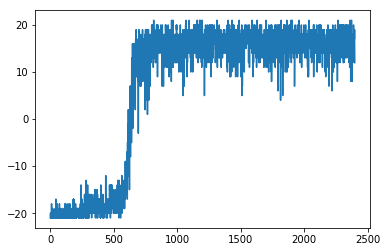

In [14]:
experiment_dir = os.path.abspath("./experiments/{}".format("PongDeterministic-v4"))
with open(os.path.join(experiment_dir, 'rewards.pkl'), "rb") as file:
    rewards = pickle.load(file)

plt.figure()
plt.plot(rewards)
plt.show()

# 14. What next?

- Methods to improve DQN: DDQN, DRQN
- Methods to improve Actor Critic: A2C, DDPG
- Method to improve Policy Gradient: TRPO, PPO

# Summary

- Q-learning in practice
    - Replay buffers
    - Target networks
- Double Q-learning

# References
1. David Silver Course: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
2. Practical Reinforcement Learning Coursera
3. Berkeley Deep Reinforcement Learning Course: http://rail.eecs.berkeley.edu/deeprlcourse